In [13]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import time
from scipy.optimize import brentq
from scipy.interpolate import interp1d, CubicSpline

Create grids for next period's capital holdings

In [40]:
def create_grids(n, theta):

    zero_grid=np.linspace(0, 1, n).reshape(-1,1)

    k_grid=np.zeros(shape=(n,1))

    k_low  = 1e-2

    k_high  = 20
    
    #for i in range(len(new_grid)):
        #k_grid[i] =  low_bound + ( up_bound - low_bound ) * (new_grid[i] ** 1)

    for i in range(len(zero_grid)):
        k_grid[i] =  (k_low) + ( (k_high) - (k_low) ) * (zero_grid[i] ** theta)

    return k_grid 

define various utility functions

In [3]:
def u(c, gamma):
    if gamma == 1:
        return np.log(c)
    else:
        return ((c ** (1 - gamma))/( 1 - gamma))

In [4]:
def u_ces(c,gamma, beta):
    return (1 - beta) * (c) ** (1-gamma)

define the production function

In [5]:
def f(A, alpha, delta, k):
    return A * (k ** alpha) + (1 - delta) * k

Now, create a function to linearly interpolate each column of the Value matrix, so that we can calculate the derivate at each point on the capital grid.

In [34]:
def interpolate_column(grid, column):
    interpolator = interp1d(np.squeeze(grid), column, kind = 'linear', fill_value = 'extrapolate')
    return interpolator

Let's now begin with the endogenous grid method

First, let's write code which does the iterations, without unpacking the solution

This code is a brute force version of egm; notice the loops. We will speed this up significantly below.

In [7]:
def egm(n_k, n_z, epsilon, theta, rho, A, alpha, delta, sigma, mu, toler, beta, gamma, max_iter): 

    start_time=time.time()

    # First, discretise an AR1 process using Rouwenhorst's method
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    z, Pi = mc.state_values, mc.P

    # Create capital, shock and resource grids
    z_grid = z

    k_grid = create_grids(n_k, theta)

    Y_grid = f(np.exp(z_grid) * A, alpha, delta, k_grid)

    #Create a matrix to store the derivatives of the interpolated value functions on the capital grid
    derivatives = np.zeros((n_k,n_z))

    # Initialise value and policy functions
    V_star = np.zeros((n_k, n_z))  
    for i in range(n_k):
        for j in range(n_z):
            V_star[i,j] = (u(np.squeeze(k_grid[i]), gamma))

    V_star_new = np.zeros((n_k, n_z))  

    interpolated_V = np.zeros((n_k,n_z))

    it = 0

    for it in range(max_iter):

        # Create list of interpolated columns
        interpolators = [interpolate_column(np.squeeze(k_grid), V_star[:,j]) for j in range(n_z)]

        # Update the derivatives
        for j, interpolator in enumerate(interpolators): # Here I changed how the loop is defined 
            for i in range(n_k):
                    derivatives[i,j]=((interpolator(k_grid[i]+epsilon)-interpolator(k_grid[i]-epsilon))/(2*epsilon))

        #Now that we have the derivatives, we can use the first-order conditions to find consumption
        c_star = (derivatives)**(-1/gamma)

        # Calculate the implied total resources
        Y_star = c_star + k_grid

        # Update the Value function
        V = u(c_star, gamma) + V_star

        #New interpolation 
        V_interpolators = [interpolate_column(Y_star[:,j], V[:,j]) for j in range(n_z)]

        # Evaluate 
        for j, interpolator in enumerate(V_interpolators): 
            for i in range(n_k):
                interpolated_V[i,j] = interpolator(Y_grid[i, j])

        # Now, calculate the updated expected value  
        for i in range(n_k):
            for j in range(n_z):   
                V_star_new[i,j] = beta * np.dot(interpolated_V[i,:], Pi[j,:]) 

        # Check error
        error = np.max((np.abs(V_star_new - V_star))/(1+np.abs(V_star)))

        if it % 100 == 0:
            print(f'Iteration {it} completed with error = {error}')

        if error < toler:
            print(f"Converged in {it} iterations")
            break

        V_star = np.copy(V_star_new)

        it+=1
    
    end_time=time.time()

    execution_time = end_time - start_time

    print(f"Execution time: {execution_time} seconds")

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(n_z):
        ax.plot(k_grid, V_star[:, j], label=f'TFP Shock {j}')

    ax.set_title('Value Function')
    ax.set_xlabel('Capital Stock')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    return V_star

C:\Users\bayle\AppData\Local\Temp\ipykernel_21072\1967046707.py:6: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)


Iteration 0 completed with error = 0.9753195264881465
Iteration 100 completed with error = 0.0004704477044744412
Iteration 200 completed with error = 8.091431299709844e-06
Converged in 252 iterations
Execution time: 34.97367477416992 seconds


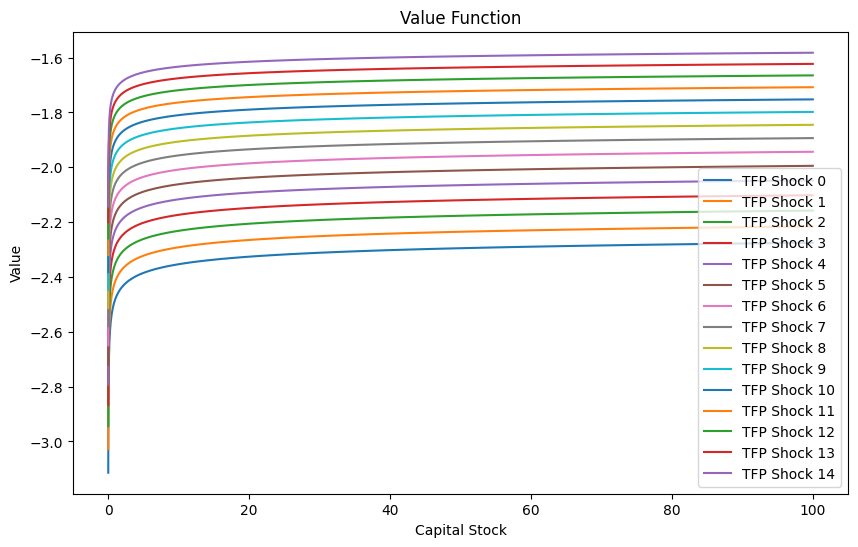

In [9]:
V = egm(n_k=101, n_z=15, epsilon=1e-4, theta=2, rho=0.98, A=10, alpha=1/3, delta=1, sigma=0.01, mu=0, toler=1e-6, beta=0.96, gamma=2, max_iter=10000000)

In [10]:
def egm_speedy(n_k, n_z, epsilon, theta, rho, A, alpha, delta, sigma, mu, toler, beta, gamma, max_iter): 
    
    start_time=time.time()
    # First, discretise an AR1 process using Rouwenhorst's method
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    z, Pi = mc.state_values, mc.P

    # Create capital, shock and resource grids
    z_grid = z

    k_grid = create_grids(n_k, theta)

    Y_grid = f(np.exp(z_grid) * A, alpha, delta, k_grid)

    #Create a matrix to store the derivatives of the interpolated value functions on the capital grid
    derivatives = np.zeros((n_k,n_z))

    # Initialise value and policy functions
    V_star = u(k_grid, gamma) * np.ones((n_k, n_z))  

    V_star_new = np.zeros((n_k, n_z))  

    interpolated_V = np.zeros((n_k,n_z))

    it = 0

    for it in range(max_iter):

        # Create list of interpolated columns
        interpolators = [interpolate_column(np.squeeze(k_grid), V_star[:,j]) for j in range(n_z)]

        # Update the derivatives
        for j, interpolator in enumerate(interpolators): # Here I changed how the loop is defined 
            derivatives[:,j]=np.squeeze((interpolator(k_grid + epsilon)-interpolator(k_grid-epsilon))/(2*epsilon))

        #Now that we have the derivatives, we can use the first-order conditions to find consumption
        c_star = (derivatives)**(-1/gamma)

        # Calculate the implied total resources
        Y_star = c_star + k_grid

        # Update the Value function
        V = u(c_star, gamma) + V_star

        #New interpolation 
        V_interpolators = [interpolate_column(Y_star[:,j], V[:,j]) for j in range(n_z)]

        # Evaluate 
        for j, interpolator in enumerate(V_interpolators): 
            interpolated_V[:,j] = interpolator(Y_grid[:, j])

        # Now, calculate the updated expected value  
        for i in range(n_k):
            for j in range(n_z):   
                V_star_new[i,j] = beta * np.dot(interpolated_V[i,:], Pi[j,:]) 

        # Check error
        error = np.max((np.abs(V_star_new - V_star))/(1+np.abs(V_star)))

        if it % 100 == 0:
            print(f'Iteration {it} completed with error = {error}')

        if error < toler:
            print(f"Converged in {it} iterations")
            break

        V_star = np.copy(V_star_new)

        it+=1

    end_time = time.time()

    execution_time = end_time - start_time

    print(f"Execution time: {execution_time} seconds")

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(n_z):
        ax.plot(k_grid, V_star[:, j], label=f'TFP Shock {j}')

    ax.set_title('Value Function')
    ax.set_xlabel('Capital Stock')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    # Plot the policy function
    #fig, ax = plt.subplots(figsize=(10, 6))
    #for j in range(n_z):
    #    ax.plot(k_grid, G_kp[:, j], label=f'TFP Shock {j}')

    #ax.set_title('Policy Function')
    #ax.set_xlabel('Current Capital Stock')
    #ax.set_ylabel('Optimal Next Period Capital Stock')
    #ax.legend()
    #plt.show()

    return V_star

C:\Users\bayle\AppData\Local\Temp\ipykernel_21072\4250419512.py:4: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)


Iteration 0 completed with error = 0.9753195264881465
Iteration 100 completed with error = 0.0004704477044744412
Iteration 200 completed with error = 8.091431299709844e-06
Converged in 252 iterations
Execution time: 1.2255444526672363 seconds


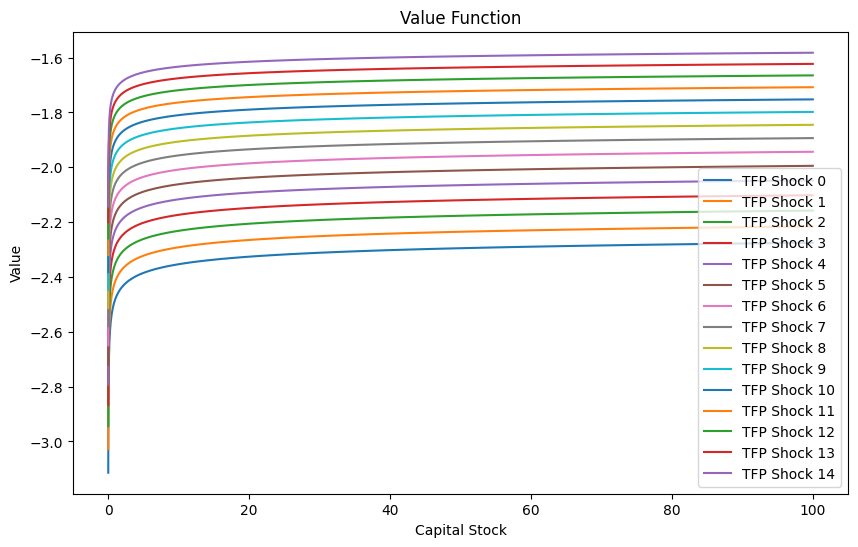

In [11]:
V = egm_speedy(n_k=101, n_z=15, epsilon=1e-4, theta=2, rho=0.98, A=10, alpha=1/3, delta=1, sigma=0.01, mu=0, toler=1e-6, beta=0.96, gamma=2, max_iter=10000000)


Work in progress from here onwards

In [56]:
def egm_speedy_corrected(n_k, n_z, epsilon, theta, rho, A, alpha, delta, sigma, mu, toler, beta, gamma, max_iter):
     
    start_time=time.time()
    # First, discretise an AR1 process using Rouwenhorst's method
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    z, Pi = mc.state_values, mc.P

    # Create capital, shock and resource grids
    z_grid = z

    k_grid = create_grids(n_k, theta)
    print(k_grid.shape)

    Y_grid = f(np.exp(z_grid) * A, alpha, delta, k_grid)

    #Create a matrix to store the derivatives of the interpolated value functions on the capital grid
    derivatives = np.zeros((n_k,n_z))

    # Initialise value and policy functions
    V_star = u(k_grid, gamma) * np.ones((n_k, n_z))  

    V_star_new = np.zeros((n_k, n_z))  

    interpolated_V = np.zeros((n_k,n_z))

    it = 0

    for it in range(max_iter):

        # Create list of interpolated columns
        interpolators = [interpolate_column(np.squeeze(k_grid), V_star[:,j]) for j in range(n_z)]

        # Update the derivatives
        for j, interpolator in enumerate(interpolators): # Here I changed how the loop is defined 
            derivatives[:,j]=np.squeeze((interpolator(k_grid + epsilon)-interpolator(k_grid-epsilon))/(2*epsilon))

        #Now that we have the derivatives, we can use the first-order conditions to find consumption
        c_star = (derivatives)**(-1/gamma)

        # Calculate the implied total resources
        Y_star = c_star + k_grid

        # Update the Value function
        V = u(c_star, gamma) + V_star

        #New interpolation 
        V_interpolators = [interpolate_column(Y_star[:,j], V[:,j]) for j in range(n_z)]

        # Evaluate 
        for j, interpolator in enumerate(V_interpolators): 
            interpolated_V[:,j] = interpolator(Y_grid[:, j])

        # Now, calculate the updated expected value  
        for i in range(n_k):
            for j in range(n_z):   
                V_star_new[i,j] = beta * np.dot(interpolated_V[i,:], Pi[j,:]) 

        # Check error
        error = np.max((np.abs(V_star_new - V_star))/(1+np.abs(V_star)))

        if it % 100 == 0:
            print(f'Iteration {it} completed with error = {error}')

        if error < toler:
            print(f"Converged in {it} iterations")
            break

        V_star = np.copy(V_star_new)

        it+=1

    # Now that we have converged. We must back out the value and policy functions.

    X = np.zeros((n_k,n_z))
    Val = np.zeros((n_k,n_z))
    pol = np.zeros((n_k,n_z))

    # Remember that our capital grid is defined on k', not k. Further,
    # our Y_star grid is not necessarily on Y_grid. We need to find the level of capital, k_star
    # such that Y_star is your optimal decision.
    # To do so, we use Brent.

    for i in range(n_k):
        for j in range(n_z):
            Eq = lambda k_star: f(np.exp(z_grid[j]) * A, alpha, delta, k_star) - Y_star[i,j]
            X[i,j] = brentq(Eq, 0, 10**5)

    # The matrix X is therefore the level of capital today implied by the 
    # you optimal decision tomorrow.

    for j in range(n_z):
        # invP creates the interpolated policy function, where we know from above that the
        # elements X map to our k' elements.
        invP = lambda x: CubicSpline(X[:,j], k_grid, bc_type = 'not-a-knot')(x)
        # Then, interpolate a function of total resources given capital today.
        # We will evaluate this function on y_grid.
        h1 = lambda x: CubicSpline(X[:,j], Y_star[:,j], bc_type = 'not-a-knot')(x)
        # Now, create a function which assigns values to total resources.
        h2 = lambda x: CubicSpline(Y_grid[:,j], V_star[:,j], bc_type = 'not-a-knot')(x)


        pol[:,j] = np.squeeze(invP(k_grid))
        # Assign a value to each level of capital using h1 and h2. First, assign a 
        # level of resources to each grid point, and then assign a value to each
        # level of resources.
        Val[:,j] = np.squeeze(h2(h1(k_grid)))

    end_time = time.time()

    execution_time = end_time - start_time

    print(f"Execution time: {execution_time} seconds")

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(n_z):
        ax.plot(k_grid, V[:, j], label=f'TFP Shock {j}')

    ax.set_title('Value Function')
    ax.set_xlabel('Capital Stock')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(n_z):
        ax.plot(k_grid, pol[:, j], label=f'TFP Shock {j}')

    ax.set_title('Policy Function')
    ax.set_xlabel('Current Capital Stock')
    ax.set_ylabel('Optimal Next Period Capital Stock')
    ax.legend()
    plt.show()

    return Val, pol

C:\Users\bayle\AppData\Local\Temp\ipykernel_21072\1549603282.py:5: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)


(501, 1)
Iteration 0 completed with error = 0.9754206241526729
Iteration 100 completed with error = 0.0004643758890786811
Iteration 200 completed with error = 7.988131766706928e-06
Converged in 251 iterations
Execution time: 4.474107265472412 seconds


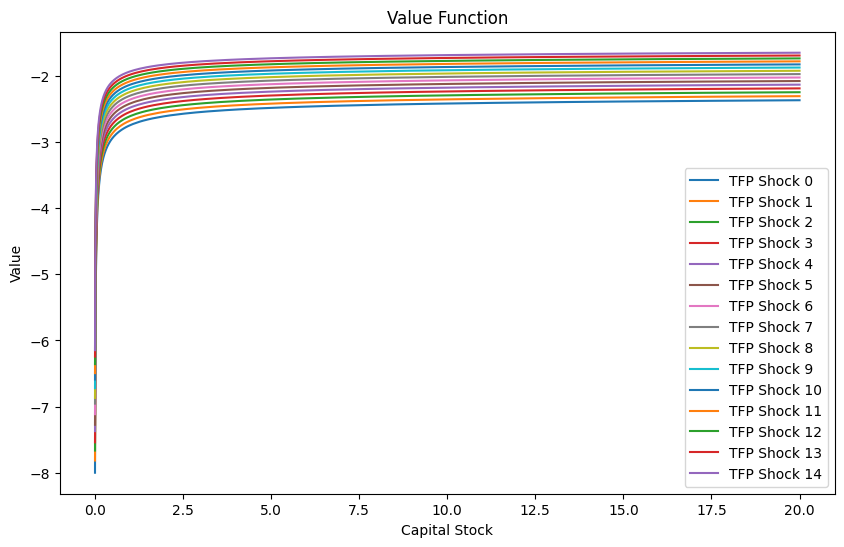

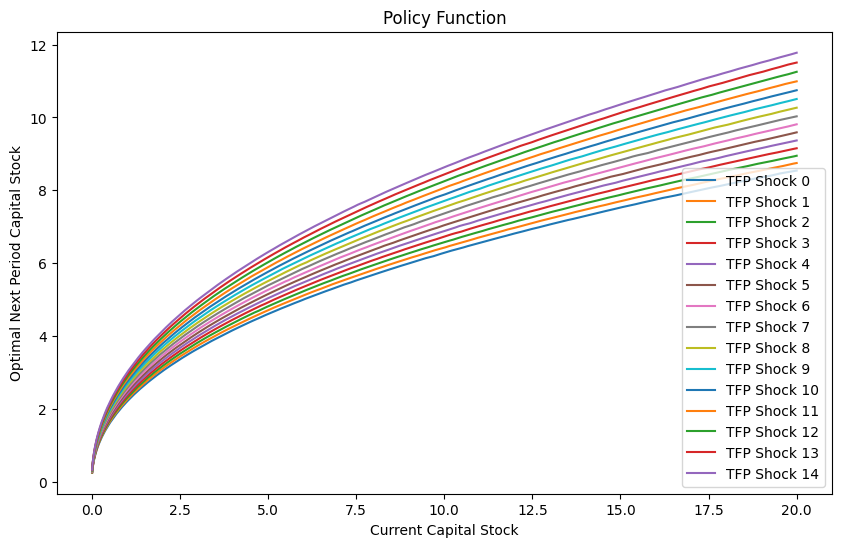

In [57]:
v, pol = egm_speedy_corrected(n_k=501, n_z=15, epsilon=1e-4, theta=2, rho=0.98, A=10, alpha=1/3, delta=1, sigma=0.01, mu=0, toler=1e-6, beta=0.96, gamma=2, max_iter=10000000)